# Regression (Ridge, Lasso)


## Dataset Preparation
The data basis comes in form of a preprocessed version of the [wine quality dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp
import pandas as pd
import io
import requests

In [3]:
X, y = cp.load(open('../data/winequality-white.pickle', 'rb'))

print(f'Data Shape (records/attributes): {X.shape}')
print(f'No. Labels: {y.shape[0]}')

Data Shape (records/attributes): (4898, 11)
No. Labels: 4898


In [4]:
# create training and test dataset using a 80/20 split

def split_data(X, y, split_coeff):
    N, _ = X.shape
    train_size = int(split_coeff * N) 
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


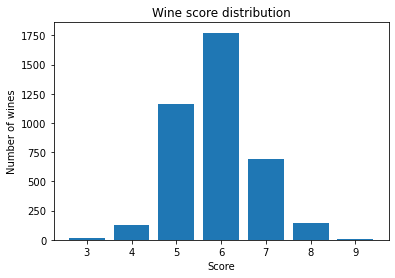

In [7]:
# inspect distribution of wine scores
def plot_bar_chart_score(X_train, y_train):
    bins = np.arange(min(y_train), max(y_train)+2)
    plt.hist(y_train, bins=bins, align='left', rwidth=.8)
    plt.gca().set(title='Wine score distribution', xlabel='Score', ylabel='Number of wines');

plot_bar_chart_score(X_train, y_train)

## Implementation of Trivial Predictor (Baseline)

In [8]:
# trivial predictor: average value of y on training dataset as prediction for a datapoint
y_train_avg = np.mean(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

def simplest_predictor(X_test, y_train_avg):
    return y_train_avg

Average of y on the training label values is 5.878764675855028


In [11]:
from sklearn.metrics import mean_squared_error

# compute mean squared error (i.e., average of squared residuals) on training and test data using trivial (=simplest) predictor
def test_data(X_test, y_test, predictor: callable=None):
    # Applies the predictor to each row to compute the predicted values
    y_predicted = np.apply_along_axis(predictor, 1, X_test)
    mse = np.square(np.subtract(y_test, y_predicted)).mean()
    return mse

mse_simplest_predictor_train = test_data(X_train, y_train, lambda x: simplest_predictor(x, y_train_avg))
mse_simplest_predictor_test = test_data(X_test, y_test, lambda x: simplest_predictor(x, y_train_avg))

print('Simplest Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_simplest_predictor_train)
print('MSE (Testing)  = %.4f' % mse_simplest_predictor_test)

Simplest Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Implementation of Linear Least Squares Model

**Data Standardization:** Standardization is effective if the data has varying scales (this could lead to uneven contributions of different features to the analysis). Furthermore standardization is useful if the model we use assumes the data to be Gaussian distributed, which is true in the case of the least squares linear regression model (i.e. linear regression from the viewpoint of Maximum Likelihood Estimation).

In [25]:
from sklearn.preprocessing import StandardScaler

def standardize_data(X):
    # standardized datapoint: z = (x - mean)/std
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    
    return X_standardized, scaler

X_train_standardized, scaler_train = standardize_data(X_train)
print(f'X_train_standardized: {X_train_standardized.shape}')
print(f'Mean of standardized training data: {[int(x) for x in X_train_standardized.mean(axis=0)]}')
print(f'Standard Deviation of standardized training data: {X_train_standardized.std(axis=0)}\n')

# standardize test data using mean and std from training data
X_test_standardized = scaler_train.transform(X_test)
print(f'X_test_standardized: {X_test_standardized.shape}')
print(f'Mean of standardized test data: {[int(x) for x in X_test_standardized.mean(axis=0)]}')
print(f'Standard Deviation of standardized training data: {X_test_standardized.std(axis=0)}')

X_train_standardized: (3918, 11)
Mean of standardized training data: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Standard Deviation of standardized training data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

X_test_standardized: (980, 11)
Mean of standardized test data: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Standard Deviation of standardized training data: [1.02757644 1.05986644 0.86133957 1.00717143 1.04074644 0.97188551
 1.01138494 1.01791956 1.03268047 1.04822853 1.02070335]


In [28]:
from sklearn.linear_model import LinearRegression

# add a column of ones (=bias column) to the front of the input matrix
def expand_with_ones(X):
    axis = 1 if X.ndim > 1 else 0
    X_out = np.insert(X, 0, values=[[1]], axis=axis)
    
    return X_out

def least_squares_compute_parameters(X_input, y):
    # add the bias column to the dataset
    X = expand_with_ones(X_input)
    coef = (np.linalg.inv(X.T @ X)) @ X.T @ y
    
    return coef

# train the linear model parameters
w = least_squares_compute_parameters(X_train_standardized, y_train) 
print(w)
print("w:", w.shape)

[ 5.87876468e+00  5.70365710e-02 -1.83384219e-01 -4.04067444e-03
  4.09097280e-01 -8.17517111e-03  5.92929519e-02 -3.56633675e-03
 -4.36936781e-01  9.87381161e-02  6.53325059e-02  2.42495455e-01]
w: (12,)


In [29]:
# Implement the linear model predictor
def linear_model_predictor(X, w):
    return np.dot(X,w)

In [46]:
# evaluate the linear model predictor
mse_linear_model_predictor = test_data(expand_with_ones(X_test_standardized), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283475


## Learning Curves

Inspect if linear model is overfitting or underfitting. General idea: start with 20 datapoints from the training dataset and increase its size in increments of 20 up to 600 datapoints. For each case, train the linear model on the current dataset. Calculate training error on this dataset and the test error on the full test set. Plot training and test error as a function of the size of the training dataset.

In [47]:
from sklearn.model_selection import train_test_split 

def train_and_test(X, y, split_coeff):
    # split input in training and test set. Assume an initial train-test-split of 80/20
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=0.8)
    X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=split_coeff)
    print(f'Size of training data: {X_train.shape}')
    
    # standardize input
    X_train_standardized, scaler_train = standardize_data(X_train)
    X_test_standardized = scaler_train.transform(X_test)
    
    # Train the linear model by computing the coefficients
    coefs = least_squares_compute_parameters(X_train_standardized, y_train)
    
    # Calculate MSE for training and test data sets.
    mse_train = test_data(expand_with_ones(X_train_standardized), y_train, lambda x: linear_model_predictor(x, coefs))
    mse_test = test_data(expand_with_ones(X_test_standardized), y_test, lambda x: linear_model_predictor(x, coefs))

    return mse_train, mse_test

Size of training data: (19, 11)
Size of training data: (39, 11)
Size of training data: (59, 11)
Size of training data: (79, 11)
Size of training data: (99, 11)
Size of training data: (119, 11)
Size of training data: (139, 11)
Size of training data: (159, 11)
Size of training data: (179, 11)
Size of training data: (199, 11)
Size of training data: (219, 11)
Size of training data: (239, 11)
Size of training data: (259, 11)
Size of training data: (279, 11)
Size of training data: (299, 11)
Size of training data: (319, 11)
Size of training data: (339, 11)
Size of training data: (359, 11)
Size of training data: (379, 11)
Size of training data: (399, 11)
Size of training data: (419, 11)
Size of training data: (439, 11)
Size of training data: (459, 11)
Size of training data: (479, 11)
Size of training data: (499, 11)
Size of training data: (519, 11)
Size of training data: (539, 11)
Size of training data: (559, 11)
Size of training data: (579, 11)
Size of training data: (599, 11)


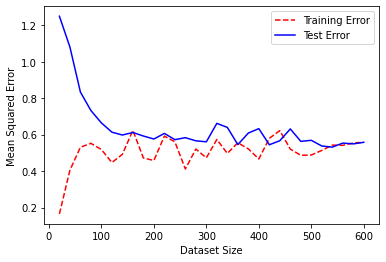

In [49]:
mse_train_vec = []
mse_test_vec = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the errors over datasets with different sizes
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20): 
    mse_train, mse_test = train_and_test(X, y, train_size/(len(X)*0.8))
    
    mse_train_vec.append(mse_train)
    mse_test_vec.append(mse_test)

# plotting
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_vec, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_vec, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## Polynomial Basis Expansion 

Procedure: try 5 powers of 10 for lambda from 10^-2 to 10^2 and use degree 2 basis expansion. Fit ridge and lasso using degree 2 polynomial expansion with these values of lambda. Pick the optimal values for lambda using a validation set. Set the last 20% of the training set for the purpose of validation.

In [50]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.linear_model import Ridge, Lasso 

In [68]:
def expand_basis(X, degree):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    
    print('\nDegree: {}'.format(degree))
    print('Number of input features: {}'.format(X.shape[1]))
    print('Number of features after transform: {}'.format(X_poly.shape[1]))
    return X_poly

In [57]:
def prepare_data(X, y, degree):
    # dataset preparation:
    # 1. training data -- X_train, y_train
    # 2. test data -- X_test, y_test
    # 3. validation data -- X_train_v, y_train_v
    # 4. training data (cross validation) -- X_train_n, y_train_n
    
    # standardize data before basis expansion
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # basis expansion
    X_poly = expand_basis(X, degree)
       
    # training data and test data
    X_train, y_train, X_test, y_test = split_data(X_poly, y, 0.8)
    
    # standardize training and test data
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.transform(X_test)
    
    # split the training data to training and validation data and standardize
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train, y_train, 0.8)
    X_train_n_standardized = scaler.fit_transform(X_train_n)
    X_train_v_standardized = scaler.transform(X_train_v)
    
    return X_train_standardized, y_train, X_train_n_standardized, y_train_n, X_train_v_standardized, y_train_v, X_test_standardized, y_test


X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

Degree: 2
Number of input features: 11
Number of features after transform: 78


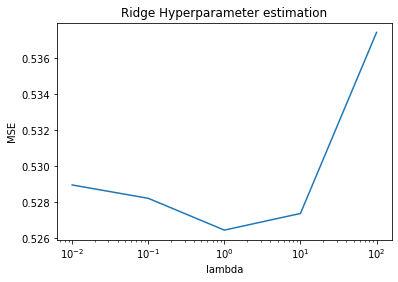

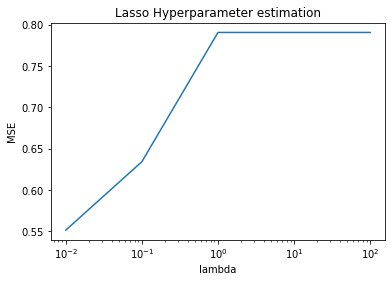

Ridge lambda: 1
Lasso lambda: 0.01


In [59]:
# find optimal hyperparameter 'lambda' for Ridge and Lasso using training and validation datasets

def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool, show_plots: bool):
    mse_arr = []
    lam_arr = []

    # Try lambda values from 10^-2 to 10^2. 
    # Record the mse and the lambda values in mse_arr and lam_arr
    for pow_lam in range(-2, 3):
        # compute lambda and save it
        lam = 10 ** pow_lam
        lam_arr.append(lam)
        # define model based on input parameter 'is_ridge'
        model = Ridge(lam) if is_ridge else Lasso(lam)
        # fit model on train split
        model.fit(X_train_n, y_train_n)
        # evaluate on validation split
        y_pred = model.predict(X_train_v)
        # compute MSE and save it
        mse_arr.append(mean_squared_error(y_train_v, y_pred))

    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr))
    # print(lam_arr[lambda_idx_min])
    
    if (show_plots):
        # plot of the lambda values and their mse
        plt.figure()
        plt.xlabel("lambda")
        plt.ylabel("MSE")
        plt.title("{} Hyperparameter estimation".format("Ridge" if is_ridge else "Lasso"))
        plt.semilogx(lam_arr, mse_arr)
        plt.show()

    # return the best lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False, True)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

In [60]:
# based on optimal hyperparameters from validation step, train models on entire training dataset. Report training and test MSE

# given polynomial degree
degree = 2

#######################
# Ridge               #
#######################
# define model
ridge = Ridge(alpha=lam_ridge)
# train on train set
ridge.fit(X_train, y_train)
# evaluate on train set 
y_pred_train = ridge.predict(X_train)
# compute train MSE
mse_ridge_train = mean_squared_error(y_train, y_pred_train)
# evaluate models on test set
y_pred_test = ridge.predict(X_test)
# compute test MSE
mse_ridge_test = mean_squared_error(y_test, y_pred_test)

#######################
# LASSO               #
#######################
# define model
lasso = Lasso(alpha=lam_lasso, max_iter=10000)  # add max_iter for convergence (values do not change)
# train on train set
lasso.fit(X_train, y_train)
# evaluate on train set 
y_pred_train = lasso.predict(X_train)
# compute train MSE
mse_lasso_train = mean_squared_error(y_train, y_pred_train)
# evaluate models on test set
y_pred_test = lasso.predict(X_test)
# compute test MSE
mse_lasso_test = mean_squared_error(y_test, y_pred_test)

# Report the result
print('For Ridge Regression using degree %d polynomial expansion and lambda = %.4f' % (degree, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso Regression using degree %d polynomial expansion and lambda = %.4f' % (degree, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression using degree 2 polynomial expansion and lambda = 1.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.4952
MSE (Testing)  = 0.5126


For Lasso Regression using degree 2 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.5180
MSE (Testing)  = 0.5268


Alternatively, higher degree basis expansion is tested. However, instead of using a separate validation set, k-fold cross validation is applied.

In [65]:
from sklearn.model_selection import KFold
from statistics import mode
from collections import Counter

In [69]:
def init_models(lam_ridge, lam_lasso):
    return Ridge(alpha=lam_ridge), Lasso(alpha=lam_lasso, max_iter=100000)

def get_best_lambda(lam_arr):
    counter = Counter(lam_arr)
    return counter.most_common(1)[0][0]

kfold_splits=10
degree_list = [3, 4, 5]

kf = KFold(n_splits=kfold_splits)
print(f'Number of splits: {kf.get_n_splits(X_train, y_train)}')

for degree in degree_list:

    lam_ridge_cv = []
    lam_lasso_cv = []
    
    # expand dataset for given degree
    X_train_deg, y_train_deg, _, _, _, _, X_test_deg, y_test_deg = prepare_data(X, y, degree)

    # use cross validation to determine hyperparameters
    for train_idx, val_idx in kf.split(X_train_deg, y_train_deg):
        # set the splits
        X_train_t, X_train_v, y_train_t, y_train_v = X_train_deg[train_idx], X_train_deg[val_idx], y_train_deg[train_idx], y_train_deg[val_idx]
        # compute lambdas
        lam_ridge_cv.append(choose_hyper_param(X_train_t, y_train_t, X_train_v, y_train_v, True, False))
        lam_lasso_cv.append(choose_hyper_param(X_train_t, y_train_t, X_train_v, y_train_v, False, False))

    # get best lambdas according to cross validation step
    lam_ridge = get_best_lambda(lam_ridge_cv)
    lam_lasso = get_best_lambda(lam_lasso_cv)
    # init models
    ridge, lasso = init_models(lam_ridge, lam_lasso)
    # fit on train set
    ridge.fit(X_train_deg, y_train_deg)
    lasso.fit(X_train_deg, y_train_deg)
    # predict on train set
    y_pred_ridge = ridge.predict(X_train_deg)
    y_pred_lasso = lasso.predict(X_train_deg)
    # compute train MSE
    mse_ridge_train = mean_squared_error(y_train_deg, y_pred_ridge)
    mse_lasso_train = mean_squared_error(y_train_deg, y_pred_lasso)
    # predict on test split
    y_pred_ridge = ridge.predict(X_test_deg)
    y_pred_lasso = lasso.predict(X_test_deg)
    # compute test MSE
    mse_ridge_test = mean_squared_error(y_test_deg, y_pred_ridge)
    mse_lasso_test = mean_squared_error(y_test_deg, y_pred_lasso)
    
    # Report the result
    print('\nFor Ridge Regression using degree %d polynomial expansion and lambda = %.4f' % (degree, lam_ridge))
    print('--------------------------------------------------------------------------------\n')
    print('MSE (Training) = %.4f' % mse_ridge_train)
    print('MSE (Testing)  = %.4f' % mse_ridge_test)

    print('\n\nFor Lasso using degree %d polynomial expansion and lambda = %.4f' % (degree, lam_lasso))
    print('---------------------------------------------------------------------\n')
    print('MSE (Training) = %.4f' % mse_lasso_train)
    print('MSE (Testing)  = %.4f' % mse_lasso_test)
    


Number of splits: 10

Degree: 3
Number of input features: 11
Number of features after transform: 364

For Ridge Regression using degree 3 polynomial expansion and lambda = 100.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.4301
MSE (Testing)  = 0.6034


For Lasso using degree 3 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.4889
MSE (Testing)  = 0.5126

Degree: 4
Number of input features: 11
Number of features after transform: 1365

For Ridge Regression using degree 4 polynomial expansion and lambda = 100.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.3511
MSE (Testing)  = 1.1321


For Lasso using degree 4 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.4699
MSE (Testing)  = 0.5226

Degree: 5
Number of inp